In [1]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
vgg19_model_path = '/content/drive/MyDrive/covid-19_model-save/VGG19.keras'
densenet201_model_path = '/content/drive/MyDrive/covid-19_model-save/DenseNet201.keras'


In [3]:
test_dir = "/content/drive/MyDrive/Covid-19_small/test"

In [4]:

test_datagen = ImageDataGenerator(rescale=1./255)
test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 192 images belonging to 4 classes.


In [5]:

vgg19_model = load_model(vgg19_model_path)
densenet201_model = load_model(densenet201_model_path)


vgg19_preds = vgg19_model.predict(test_gen, verbose=1)
densenet201_preds = densenet201_model.predict(test_gen, verbose=1)


ensemble_preds = (vgg19_preds + densenet201_preds) / 2
ensemble_labels = np.argmax(ensemble_preds, axis=1)


y_true = test_gen.classes


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


6/6 ━━━━━━━━━━━━━━━━━━━━ 192s 32s/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 82s 10s/step


In [14]:
densenet_loss, densenet_acc, densenet_auc = densenet201_model.evaluate(test_gen, verbose=1)
print(f"DenseNet201 Test Accuracy: {densenet_acc:.4f}, Test AUC: {densenet_auc:.4f}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 98s 10s/step - accuracy: 0.8237 - auc: 0.9692 - loss: 0.4326
DenseNet201 Test Accuracy: 0.8542, Test AUC: 0.9740


In [15]:
vgg_loss, vgg_acc, vgg_auc = vgg19_model.evaluate(test_gen, verbose=1)
print(f"VGG19 Test Accuracy: {vgg_acc:.4f}, Test AUC: {vgg_auc:.4f}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 190s 28s/step - accuracy: 0.6626 - auc: 0.8773 - loss: 0.8162
VGG19 Test Accuracy: 0.7500, Test AUC: 0.9292


In [6]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
accuracy = accuracy_score(y_true, ensemble_labels)
print(f"Ensemble Test Accuracy: {accuracy:.4f}")

Ensemble Test Accuracy: 0.8281


In [7]:
print("\nClassification Report:\n")
print(classification_report(y_true, ensemble_labels, target_names=list(test_gen.class_indices.keys())))


Classification Report:

                 precision    recall  f1-score   support

          COVID       0.83      0.75      0.79        52
   Lung_Opacity       0.83      0.83      0.83        48
         Normal       0.76      0.80      0.78        55
Viral Pneumonia       0.92      0.97      0.95        37

       accuracy                           0.83       192
      macro avg       0.84      0.84      0.84       192
   weighted avg       0.83      0.83      0.83       192



In [8]:
cm = confusion_matrix(y_true, ensemble_labels)
print("\nConfusion Matrix:\n", cm)


Confusion Matrix:
 [[39  6  7  0]
 [ 2 40  6  0]
 [ 6  2 44  3]
 [ 0  0  1 36]]


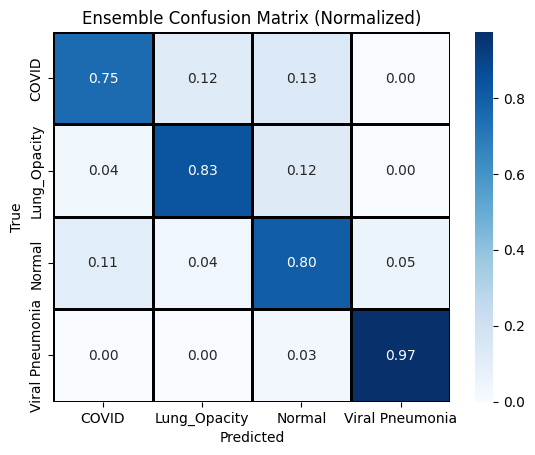

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_true, ensemble_labels)
class_labels = list(test_gen.class_indices.keys())

# Normalize for visualization (optional)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

#plt.figure(figsize=(6,5))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels,
            cbar=True, linecolor='black', linewidth=1)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Ensemble Confusion Matrix (Normalized)')
plt.show()


In [13]:
import tensorflow as tf
auc = roc_auc_score(tf.keras.utils.to_categorical(y_true), ensemble_preds, multi_class='ovr', average='macro')
print(f"Ensemble Test AUC (macro): {auc:.4f}")

Ensemble Test AUC (macro): 0.9693
